# Load Packages

In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys

!pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
from rarfile import RarFile
import segmentation_models as sm
from keras_segmentation.models import segnet
from keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-12-08 01:21:05.105605: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-7t66h194
  Running command git clone --filter=blob:none --quiet https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-7t66h194
  Resolved https://github.com/davej23/image-segmentation-keras.git to commit e01b0a8d5859854cd9d259a618829889166439f5
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Segmentation Models: using `keras` framework.


In [3]:
# Specify whether to download data or read in
download = False
base_dir = r"./Amazon Forest Dataset/"

In [4]:
# Download data

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data.rar').extractall('')

    else:
        with RarFile('data.rar') as rf:
            rf.extractall()

base_dir = r"./Amazon Forest Dataset/"

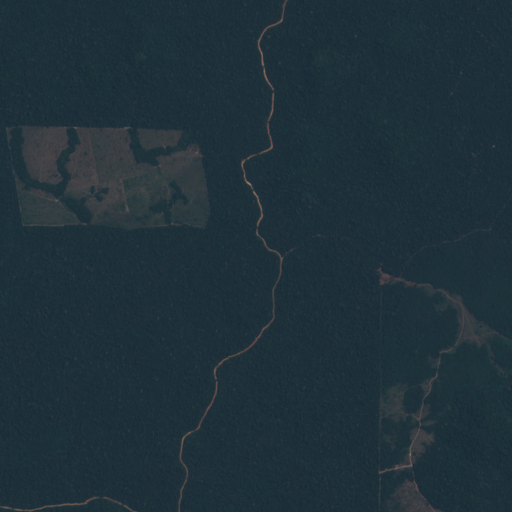

In [5]:
# Show example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

# Functions

In [7]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [8]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [9]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def iou_eval(model, image, mask): # Find IoU (Intersection over Union) score for 3-channel images
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()
    mask_flat = mask.flatten()

    # Calculate IoU using jaccard_score (IoU is the same as Jaccard index for binary classification)
    return jaccard_score(mask_flat, reconstruction, average='weighted', zero_division=0)

  else: # If a list of images input, find IoU for each
    iou_scores = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
        reconstruction = np.round(reconstruction).flatten()
        mask_flat = mask[i].flatten()

        iou_scores.append(jaccard_score(mask_flat, reconstruction, average='weighted', zero_division=0))

    return iou_scores

def iou_eval2(model, image, mask): # Find IoU (Intersection over Union) score for 4-channel images
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()
    mask_flat = mask.flatten()

    # Calculate IoU using jaccard_score (IoU is the same as Jaccard index for binary classification)
    return jaccard_score(mask_flat, reconstruction, average='weighted', zero_division=0)

  else: # If a list of images input, find IoU for each
    iou_scores = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
        reconstruction = np.round(reconstruction).flatten()
        mask_flat = mask[i].flatten()

        iou_scores.append(jaccard_score(mask_flat, reconstruction, average='weighted', zero_division=0))

    return iou_scores

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Ingest and Process RGB Dataset

In [10]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [11]:
# Pre-process data, normalise and reshape
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

# Remove five images from training data, which has been added to validation data
training_images = training_images[0:25]
training_masks = training_masks[0:25]

In [12]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

2025-12-08 01:21:36.144674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 01:21:36.834721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:b2:00.0, compute capability: 8.9


In [13]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [14]:
#
# Produce generators for training images
#

t_images = np.stack(training_images)
t_masks = np.stack(training_masks)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

# Ingest and Process 4-band Datasets

## 4-band Amazon dataset

In [15]:
download = False # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [16]:
# Download data (Amazon)

if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()


In [17]:
# Ingest images and normalise
"""
## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)
""" 
import os
import numpy as np
import rioxarray as rxr

# 你的路径设置
base_dir2 = r"./AMAZON/"

# --- 定义一个简单的过滤函数 ---
def get_clean_file_list(directory):
    # 只返回以 .tif 或 .tiff 结尾的文件
    return sorted([f for f in os.listdir(directory) if f.endswith('.tif') or f.endswith('.tiff')])

# ==========================================
# 1. Training images & masks
# ==========================================
# 使用过滤函数，避开 .ipynb_checkpoints
all_train_files = get_clean_file_list(r"{}Training/image/".format(base_dir2))
training_images_list2 = all_train_files[0:250] # 原作者只取前250张

training_masks_list2 = []
training_images2 = []

print(f"Loading Training Data ({len(training_images_list2)} images)...")
for n in training_images_list2:
    training_masks_list2.append(n)
    # 读取 Image
    try:
        a = np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n)))
        # 归一化，防止分母为0
        denom = np.max(a) - np.min(a)
        if denom == 0: denom = 1
        a = (a - np.min(a)) / denom
        training_images2.append(a)
    except Exception as e:
        print(f"Skipping bad file: {n}")

## Training masks (对应的 Mask)
training_masks2 = []
for n in training_masks_list2:
    try:
        a = np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n)))
        training_masks2.append(a)
    except Exception as e:
        print(f"Skipping bad mask: {n}")

# ==========================================
# 2. Test images & masks
# ==========================================
# 同样使用过滤函数
test_images_list2 = get_clean_file_list(r"{}Test/image/".format(base_dir2))

test_masks_list2 = []
test_images2 = []

print(f"Loading Test Data ({len(test_images_list2)} images)...")
for n in test_images_list2:
    test_masks_list2.append(n)
    try:
        a = np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n)))
        denom = np.max(a) - np.min(a)
        if denom == 0: denom = 1
        a = (a - np.min(a)) / denom
        test_images2.append(a)
    except Exception as e:
        print(f"Skipping bad file: {n}")

## Test masks
test_masks2 = []
for n in test_masks_list2:
    try:
        a = np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n)))
        test_masks2.append(a)
    except Exception as e:
        print(f"Skipping bad mask: {n}")

# ==========================================
# 3. Validation images & masks
# ==========================================
# 同样使用过滤函数
validation_images_list2 = get_clean_file_list(r"{}Validation/images/".format(base_dir2))

validation_masks_list2 = []
validation_images2 = []

print(f"Loading Validation Data ({len(validation_images_list2)} images)...")
for n in validation_images_list2:
    validation_masks_list2.append(n)
    try:
        a = np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n)))
        denom = np.max(a) - np.min(a)
        if denom == 0: denom = 1
        a = (a - np.min(a)) / denom
        validation_images2.append(a)
    except Exception as e:
        print(f"Skipping bad file: {n}")

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
    try:
        a = np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n)))
        validation_masks2.append(a)
    except Exception as e:
        print(f"Skipping bad mask: {n}")

print("✅ Data loading complete!")

Loading Training Data (250 images)...
Loading Test Data (20 images)...
Loading Validation Data (100 images)...
✅ Data loading complete!


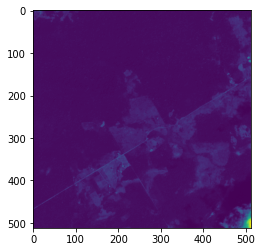

In [18]:
# Show example train image
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

In [19]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [20]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

## 4-band Atlantic Forest dataset

In [21]:
download = False # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [22]:
# Download data (Atlantic Forest)
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()


In [23]:
# Ingest images and normalise

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [24]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

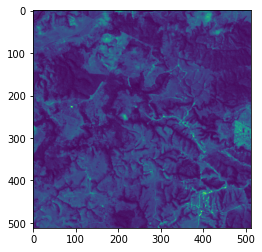

In [25]:
# Plot example training image first band
plt.imshow(training_images3[0].reshape(512,512,4)[:,:,0])

In [26]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

# Models

## U-Net

In [27]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  U-Net model
'''
#这里要改3/4
def UNet(trained_weights = None, input_size = (512,512,4), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [28]:
# Print model layers and number of parameters
UNet().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 512, 512, 4)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (1, 512, 512, 64)    2368        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (1, 512, 512, 64)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (1, 512, 512, 64)    36928       ['activation[0][0]']             
                                                                                              

## Attention U-Net

In [29]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [30]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_19 (Conv2D)             (1, 512, 512, 16)    448         ['input_2[0][0]']                
                                                                                                  
 activation_19 (Activation)     (1, 512, 512, 16)    0           ['conv2d_19[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (1, 512, 512, 16)    2320        ['activation_19[0][0]']          
                                                                                            

## ResNet50-SegNet

In [31]:
# Forked code from: https://github.com/ykamikawa/tf-keras-SegNet

from keras.layers import Layer

'''
  Unpooling using max pooling indices
'''

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        padding = 'same'
        pool_size = (2,2)
        strides = (2,2)
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

# Custom version of MaxUnpooling2D
# Takes raw layer values and outputs values
# Takes tf.nn.max_pool_with_argmax output as input
def unpool_with_indices(pool, indices, out_size=2):
  print(pool)
  print(indices)
  # Create empty array of appropriate size
  shape = np.array(np.shape(pool))
  shape = np.array((shape[0], out_size * shape[1], out_size * shape[2], shape[3]))
  out = np.zeros(shape)

  # Make upsample
  inds = np.array(indices).flatten()
  outs = np.array(pool).flatten()
  for i in range(len(inds)):
    blk = inds[i] // (shape[2] * shape[3]) # Find which block to place numbers in
    ln  = inds[i] - (blk * shape[3] * shape[2]) # Find which line
    ln2 = ln // (shape[3]) # Find line
    pos = ln % (shape[3]) # Find position
    #print(blk, ln2, pos)
    out[0][blk][ln2][pos] = outs[i]


  #print(out.shape)
  return (out)

# Own custom code
'''
  ResNet Contraction Phase Block
'''

def resnetConvDownBlock(x, filter, kernel, act='relu'):
  # Convolutional Block for encoding phase
  for i in range(3):
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
    x = Activation('relu')(x)
    
  return x

'''
  SegNet Expansion Phase Block
'''
def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
  # Convolutional block for decoding phase
  
  out = x

  # Unpooling
  out = UpSampling2D((2,2))(out)

  # Conv Block
  for i in range(3):
    out = ZeroPadding2D((1,1))(out)
    out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
    out = Activation('relu')(out)

  # Implement skip connection
  if skip_connection != None:
    out = Add()([out, skip_connection])

  return out

def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 64, kernel_sz = 3):

  inputs = Input(input_size)

  # Encoder
  # Conv, Conv, Conv, MaxPool #1
  block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
  pool1, mask1 = MaxPoolingWithArgmax2D((2,2))(block1)
  # Conv, Conv, Conv, MaxPool #2
  block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
  pool2, mask2 = MaxPoolingWithArgmax2D((2,2))(block2)
  # Conv, Conv, Conv, MaxPool #3
  block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
  pool3, mask3 = MaxPoolingWithArgmax2D((2,2))(block3)
  # Conv, Conv, Conv, MaxPool #4
  block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
  pool4, mask4 = MaxPoolingWithArgmax2D((2,2))(block4)
  # Conv, Conv, Conv, MaxPool #5
  block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
  pool5, mask5 = MaxPoolingWithArgmax2D((2,2))(block5)

  # Decoder
  # ConvTranspose + Concat, Conv, Conv, Conv #1
  block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #2
  block4_ = resnetConvUpBlock(block5_, skip_connection = MaxUnpooling2D((2,2))([pool4, mask4]), filter = 8 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #3
  block3_ = resnetConvUpBlock(block4_, skip_connection = MaxUnpooling2D((2,2))([pool3, mask3]), filter = 4 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #4
  block2_ = resnetConvUpBlock(block3_, skip_connection = MaxUnpooling2D((2,2))([pool2, mask2]), filter = 2 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #5
  block1_ = resnetConvUpBlock(block2_, skip_connection = MaxUnpooling2D((2,2))([pool1, mask1]), filter = filters, kernel = kernel_sz)
  
  # Output
  outputs = Conv2D(1, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal')(block1_)
  outputs = Activation('sigmoid')(outputs)

  model = Model(inputs, outputs)
  model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

  return model

In [32]:
# Print model layers and number of parameters
ResNet50SegNet().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 514, 514, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 512, 512, 64  1792        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

## FCN32-VGG16

In [33]:
# Code forked and modified from: https://github.com/divamgupta/image-segmentation-keras

'''
  FCN32-VGG16 model
'''

def fcn_32(input_size = (512,512,3), lr = 0.0001, drop_rate = 0):
  
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    # Input
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    ## Encoder
    # Block 1
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    # Decoder
    o = (Conv2D(4096, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)
    o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)

    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(1, kernel_size=(64,64), padding='same', strides=(32,32), name="Upsample32")(o)
    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="output"))(o)

    # Output
    o = Activation('sigmoid')(o)

    model = Model(inputs, o)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])
    model.model_name = "fcn_32"
    return model

In [34]:
# Print model layers and number of parameters
fcn_32().summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 activation_77 (Activation)  (None, 512, 512, 64)      0         
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 activation_78 (Activation)  (None, 512, 512, 64)      0         
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     7385

## ResUNet

In [35]:
import tensorflow as tf

def res_block_initial(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer for first layer
    In the residual unet the first residual block does not contain an
    initial batch normalization and activation so we create this separate
    block for it.
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]
            
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                kernel_size=1,
                                strides=1,
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])
    
    return x1

def res_block(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer
    Consists of batch norm and relu, folowed by conv, batch norm and relu and 
    final convolution. The input is then put through 
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    #x1 = tf.keras.layers.BatchNormalization()(x)
    #x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Activation('relu')(x)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                    kernel_size=1,
                                    strides=strides[0],
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
                                                            
    x1 = tf.keras.layers.Add()([x, x1])

    return x1


def upsample(x, target_size):
    """"Upsampling function, upsamples the feature map
    Deep Residual Unet paper does not describe the upsampling function 
    in detail. Original Unet uses a transpose convolution that downsamples 
    the number of feature maps. In order to restrict the number of 
    parameters here we use a bilinear resampling layer. This results in 
    the concatentation layer concatenting feature maps with n and n/2 
    features as opposed to n/2  and n/2 in the original unet.
    Args:
        x: tensor, feature map
        target_size: size to resize feature map to
    Returns:
        x_resized: tensor, upsampled feature map
    """

    x_resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, target_size))(x)

    return x_resized
        
def encoder(x, num_filters, kernel_size):
    """Unet encoder
    Args:
        x: tensor, output from previous layer
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        encoder_output: list, output from all encoder layers
    """

    x = res_block_initial(x, [num_filters[0]], kernel_size, strides=[1,1], name='layer1')

    encoder_output = [x]
    for i in range(1, len(num_filters)):
        layer = 'encoder_layer' + str(i)
        x = res_block(x, [num_filters[i]], kernel_size, strides=[2,1], name=layer)
        encoder_output.append(x)

    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    """Unet decoder
    Args:
        x: tensor, output from previous layer
        encoder_output: list, output from all previous encoder layers
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        x: tensor, output from last layer of decoder
    """

    for i in range(1, len(num_filters) + 1):
        layer = 'decoder_layer' + str(i)
        target_size = encoder_output[-i].shape[1:3]
        x = upsample(x, target_size)
        x = tf.keras.layers.Concatenate(axis=-1)([x, encoder_output[-i]])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1,1], name=layer)

    return x


def res_unet(input_size, num_filters, kernel_size, num_channels, num_classes, lr = 0.0001, out_layer = 'sigmoid', lossfunc='binary_crossentropy', num_out=1):
    """Residual Unet
    Function that generates a residual unet
    Args:
        input_size: int, dimension of the input image
        num_layers: int, number of layers in the encoder half, excludes bridge
        num_filters: list, number of filters for each encoder layer
        kernel_size: size of the kernel, applied to all convolutions
        num_channels: int, number of channels for the input image
        num_classes: int, number of output classes for the output
    Returns:
        model: tensorflow keras model for residual unet architecture
    """

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])

    encoder_output = encoder(x, num_filters, kernel_size)

    # bridge layer, number of filters is double that of the last encoder layer
    bridge = res_block(encoder_output[-1], [num_filters[-1]*2], kernel_size, 
                        strides=[2,1], name='bridge')

    decoder_output = decoder(bridge, encoder_output, num_filters, kernel_size)

    output = tf.keras.layers.Conv2D(num_classes, 
                                    kernel_size, 
                                    strides=1, 
                                    padding='same', 
                                    kernel_initializer = 'he_normal',
                                    name='output')(decoder_output)

    output = Activation(out_layer)(output)

    model = tf.keras.Model(x, output)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = lossfunc, metrics=['accuracy', 'mse'])

    return model

In [36]:
res_unet(512, [64, 128, 256, 512], 3, 3, 1).summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 layer1_1 (Conv2D)              (None, 512, 512, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 activation_93 (Activation)     (None, 512, 512, 64  0           ['layer1_1[0][0]']               
                                )                                                           

# Train on RGB feature data

## U-Net

In [37]:
# Train U-Net with generator
model_unet = UNet(input_size=(512,512,3), lr=0.0001)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_unet.fit(train, steps_per_epoch=100, epochs=30, validation_data = validation_df, callbacks=[save_model])

Epoch 1/30


2025-12-08 01:33:07.036897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-12-08 01:33:08.097032: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-12-08 01:33:08.097061: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-12-08 01:33:08.097146: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


100/100 [==============================] - ETA: 0s - loss: 0.4929 - accuracy: 0.7658 - mse: 0.1618
Epoch 1: val_accuracy improved from -inf to 0.89333, saving model to unet-3d.hdf5
100/100 [==============================] - 17s 106ms/step - loss: 0.4929 - accuracy: 0.7658 - mse: 0.1618 - val_loss: 0.2686 - val_accuracy: 0.8933 - val_mse: 0.0788
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.9099 - mse: 0.0695
Epoch 2: val_accuracy improved from 0.89333 to 0.89650, saving model to unet-3d.hdf5
100/100 [==============================] - 12s 118ms/step - loss: 0.2503 - accuracy: 0.9099 - mse: 0.0695 - val_loss: 0.2552 - val_accuracy: 0.8965 - val_mse: 0.0775
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9168 - mse: 0.0633
Epoch 3: val_accuracy did not improve from 0.89650
100/100 [==============================] - 10s 105ms/step - loss: 0.2231 - accuracy: 0.9168 - mse: 0.0633 - val_loss: 0.3120 - val_

In [38]:
# Save model training history
np.save('unet-3d-history.npy',model_unet.history.history)

In [39]:
# Copy models to drive
#!cp unet-3d.hdf5 drive/MyDrive/Diss/
#!cp unet-3d-history.npy drive/MyDrive/Diss/
import os, shutil

save_dir = "/root/autodl-tmp/attention-mechanism-unet/saved_models"
os.makedirs(save_dir, exist_ok=True)

shutil.copy("unet-3d.hdf5", os.path.join(save_dir, "unet-3d.hdf5"))
shutil.copy("unet-3d-history.npy", os.path.join(save_dir, "unet-3d-history.npy"))

'/root/autodl-tmp/attention-mechanism-unet/saved_models/unet-3d-history.npy'

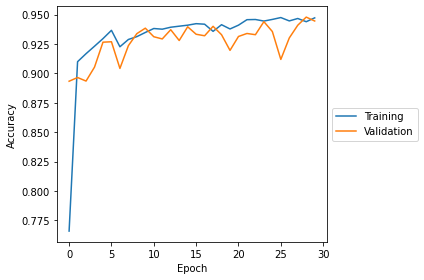

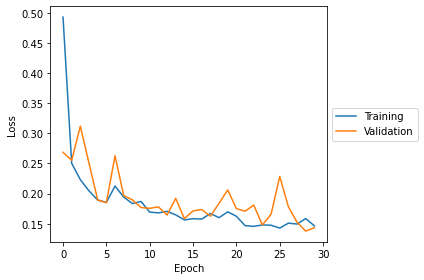

In [40]:
# Plot accuracy and loss 
"""
## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
"""
## Accuracy
plt.figure(figsize=(6,4))
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


plt.legend(['Training', 'Validation'], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


## Loss
plt.figure(figsize=(6,4))
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')


plt.legend(['Training', 'Validation'], loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


## Attention U-Net

In [41]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_model_am = ModelCheckpoint('unet-attention-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model_am])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.4429 - accuracy: 0.8310 - mse: 0.1425
Epoch 1: val_accuracy improved from -inf to 0.83604, saving model to unet-attention-3d.hdf5
100/100 [==============================] - 13s 103ms/step - loss: 0.4429 - accuracy: 0.8310 - mse: 0.1425 - val_loss: 0.4545 - val_accuracy: 0.8360 - val_mse: 0.1340
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.2435 - accuracy: 0.9155 - mse: 0.0669
Epoch 2: val_accuracy improved from 0.83604 to 0.88885, saving model to unet-attention-3d.hdf5
100/100 [==============================] - 10s 98ms/step - loss: 0.2435 - accuracy: 0.9155 - mse: 0.0669 - val_loss: 0.3015 - val_accuracy: 0.8888 - val_mse: 0.0870
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9204 - mse: 0.0618
Epoch 3: val_accuracy improved from 0.88885 to 0.90894, saving model to unet-attention-3d.hdf5
100/100 [==============================] - 11s 111ms/step

In [42]:
# Save model history
np.save('unet-attention-3d-history.npy',model_attention_unet.history.history)


In [43]:
# Copy models to drive
#!cp unet-attention-3d.hdf5 drive/MyDrive/Diss/
#!cp unet-attention-3d-history.npy drive/MyDrive/Diss/

## ResNet50-SegNet

In [44]:
R = ResNet50SegNet()
save_model_resnet = ModelCheckpoint('resnet50segnet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data = validation_df, epochs = 20, steps_per_epoch = 100, callbacks=[save_model_resnet])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.6689 - mse: 0.2177
Epoch 1: val_accuracy improved from -inf to 0.90938, saving model to resnet50segnet-3d.hdf5
100/100 [==============================] - 17s 141ms/step - loss: 0.6378 - accuracy: 0.6689 - mse: 0.2177 - val_loss: 0.3772 - val_accuracy: 0.9094 - val_mse: 0.1072
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8998 - mse: 0.0811
Epoch 2: val_accuracy did not improve from 0.90938
100/100 [==============================] - 12s 118ms/step - loss: 0.2921 - accuracy: 0.8998 - mse: 0.0811 - val_loss: 0.2390 - val_accuracy: 0.9036 - val_mse: 0.0721
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.9153 - mse: 0.0677
Epoch 3: val_accuracy did not improve from 0.90938
100/100 [==============================] - 13s 125ms/step - loss: 0.2509 - accuracy: 0.9153 - mse: 0.0677 - val_loss: 0.2919 - val_accuracy: 0.9

In [45]:
# Save model history
np.save('resnet50segnet-3d-history.npy',R.history.history)

In [46]:
# Copy models to drive
#!cp resnet50segnet-3d.hdf5 drive/MyDrive/Diss/models/
#!cp resnet50segnet-3d-history.npy drive/MyDrive/Diss/models/

## FCN32-VGG16

In [47]:
F = fcn_32(lr = 0.0001)
save_model_fcn32 = ModelCheckpoint('fcn32-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
F.fit(train, validation_data = validation_df, epochs=50, steps_per_epoch = 100, shuffle = True, callbacks=[save_model_fcn32])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4923 - mse: 0.2500
Epoch 1: val_accuracy improved from -inf to 0.49259, saving model to fcn32-3d.hdf5
100/100 [==============================] - 15s 136ms/step - loss: 0.6932 - accuracy: 0.4923 - mse: 0.2500 - val_loss: 0.6932 - val_accuracy: 0.4926 - val_mse: 0.2500
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5298 - mse: 0.2500
Epoch 2: val_accuracy did not improve from 0.49259
100/100 [==============================] - 11s 106ms/step - loss: 0.6931 - accuracy: 0.5298 - mse: 0.2500 - val_loss: 0.6932 - val_accuracy: 0.4926 - val_mse: 0.2500
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5302 - mse: 0.2500
Epoch 3: val_accuracy improved from 0.49259 to 0.49324, saving model to fcn32-3d.hdf5
100/100 [==============================] - 13s 126ms/step - loss: 0.6931 - accuracy: 0.5302 - mse: 0.2500 - val_loss: 

In [48]:
# Save model history
np.save('fcn32-3d-history.npy', F.history.history)

In [49]:
# Copy models to drive
#!cp fcn32-3d.hdf5 drive/MyDrive/Diss/
#!cp fcn32-3d-history.npy drive/MyDrive/Diss/

## ResUNet

In [50]:
R = res_unet(512, [64, 128, 256, 512], 3, 3, 1)
save_model_resunet = ModelCheckpoint('resunet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data = validation_df, epochs = 20, steps_per_epoch = 100, callbacks=[save_model_resunet])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 2.8109 - accuracy: 0.8200 - mse: 0.1588
Epoch 1: val_accuracy improved from -inf to 0.89256, saving model to resunet-3d.hdf5
100/100 [==============================] - 14s 113ms/step - loss: 2.8109 - accuracy: 0.8200 - mse: 0.1588 - val_loss: 0.3335 - val_accuracy: 0.8926 - val_mse: 0.0866
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.9076 - mse: 0.0725
Epoch 2: val_accuracy improved from 0.89256 to 0.91184, saving model to resunet-3d.hdf5
100/100 [==============================] - 11s 113ms/step - loss: 0.2786 - accuracy: 0.9076 - mse: 0.0725 - val_loss: 0.2296 - val_accuracy: 0.9118 - val_mse: 0.0665
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9148 - mse: 0.0651
Epoch 3: val_accuracy did not improve from 0.91184
100/100 [==============================] - 11s 113ms/step - loss: 0.2410 - accuracy: 0.9148 - mse: 0.0651 - val_lo

In [51]:
# Save model history
np.save('resunet-3d-history.npy',R.history.history)

In [52]:
# Copy models to drive
#!cp resunet-3d.hdf5 drive/MyDrive/Diss/models/
#!cp resunet-3d-history.npy drive/MyDrive/Diss/models/

# Train on 4-band data

## Train on 4-band Amazon data

### U-Net

In [53]:
# Train U-Net with generator
model_unet_4band = UNet()
save_model_4band = ModelCheckpoint('unet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band.fit(train_df_4band_amazon, epochs = 80, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/80
249/250 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.8946 - mse: 0.0791
Epoch 1: val_accuracy improved from -inf to 0.70771, saving model to unet-4d.hdf5
250/250 [==============================] - 13s 46ms/step - loss: 0.2648 - accuracy: 0.8936 - mse: 0.0799 - val_loss: 0.5173 - val_accuracy: 0.7077 - val_mse: 0.1819
Epoch 2/80
249/250 [============================>.] - ETA: 0s - loss: 0.1977 - accuracy: 0.9277 - mse: 0.0564
Epoch 2: val_accuracy improved from 0.70771 to 0.76950, saving model to unet-4d.hdf5
250/250 [==============================] - 11s 43ms/step - loss: 0.2009 - accuracy: 0.9266 - mse: 0.0574 - val_loss: 0.5337 - val_accuracy: 0.7695 - val_mse: 0.1662
Epoch 3/80
249/250 [============================>.] - ETA: 0s - loss: 0.1733 - accuracy: 0.9379 - mse: 0.0486
Epoch 3: val_accuracy improved from 0.76950 to 0.78075, saving model to unet-4d.hdf5
250/250 [==============================] - 11s 45ms/step - loss: 0.1767 - accuracy: 0.93

In [54]:
# Save model history
np.save('unet-4d-history.npy',model_unet_4band.history.history)

In [55]:
# Copy models to drive
#!cp unet-4d.hdf5 drive/MyDrive/Diss/
#!cp unet-4d-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [56]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('unet-attention-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 150, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/150
249/250 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8831 - mse: 0.0883
Epoch 1: val_accuracy improved from -inf to 0.75268, saving model to unet-attention-4d.hdf5
250/250 [==============================] - 11s 35ms/step - loss: 0.2931 - accuracy: 0.8821 - mse: 0.0891 - val_loss: 0.5129 - val_accuracy: 0.7527 - val_mse: 0.1699
Epoch 2/150
250/250 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9232 - mse: 0.0588
Epoch 2: val_accuracy improved from 0.75268 to 0.78807, saving model to unet-attention-4d.hdf5
250/250 [==============================] - 8s 31ms/step - loss: 0.2060 - accuracy: 0.9232 - mse: 0.0588 - val_loss: 0.5321 - val_accuracy: 0.7881 - val_mse: 0.1589
Epoch 3/150
249/250 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9379 - mse: 0.0477
Epoch 3: val_accuracy did not improve from 0.78807
250/250 [==============================] - 7s 30ms/step - loss: 0.1743 - accuracy: 0.9367 - mse: 0.0

In [57]:
# Save model history
np.save('unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

In [58]:
# Copy models to drive
#!cp unet-attention-4d.hdf5 drive/MyDrive/Diss/
#!cp unet-attention-4d-history.npy drive/MyDrive/Diss/

### ResNet50-SegNet

In [59]:
R_4band = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band = ModelCheckpoint('resnet50segnet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resnet_4band])

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8418 - mse: 0.1161
Epoch 1: val_accuracy improved from -inf to 0.76521, saving model to resnet50segnet-4d.hdf5
250/250 [==============================] - 29s 102ms/step - loss: 0.3724 - accuracy: 0.8418 - mse: 0.1161 - val_loss: 0.5121 - val_accuracy: 0.7652 - val_mse: 0.1770
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9173 - mse: 0.0716
Epoch 2: val_accuracy improved from 0.76521 to 0.82929, saving model to resnet50segnet-4d.hdf5
250/250 [==============================] - 25s 102ms/step - loss: 0.2483 - accuracy: 0.9173 - mse: 0.0716 - val_loss: 0.4191 - val_accuracy: 0.8293 - val_mse: 0.1275
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9307 - mse: 0.0549
Epoch 3: val_accuracy did not improve from 0.82929
250/250 [==============================] - 24s 98ms/step - loss: 0.1956 - accuracy: 0.9307 - mse: 0.

In [60]:
# Save model history
np.save('resnet50segnet-4d-history.npy', R_4band.history.history)

In [61]:
# Copy models to drive
#!cp resnet50segnet-4d.hdf5 drive/MyDrive/Diss/models/
#!cp resnet50segnet-4d-history.npy drive/MyDrive/Diss/models/

### FCN32-VGG16

In [62]:
F_4band = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn_4band = ModelCheckpoint('fcn32-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
F_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 50, callbacks=[save_model_fcn_4band])

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5638 - mse: 0.2484
Epoch 1: val_accuracy improved from -inf to 0.51225, saving model to fcn32-4d.hdf5
250/250 [==============================] - 19s 71ms/step - loss: 0.6902 - accuracy: 0.5638 - mse: 0.2484 - val_loss: 0.6908 - val_accuracy: 0.5123 - val_mse: 0.2488
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.5429 - accuracy: 0.7154 - mse: 0.1846
Epoch 2: val_accuracy improved from 0.51225 to 0.58983, saving model to fcn32-4d.hdf5
250/250 [==============================] - 17s 68ms/step - loss: 0.5429 - accuracy: 0.7154 - mse: 0.1846 - val_loss: 0.5889 - val_accuracy: 0.5898 - val_mse: 0.2056
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.8377 - mse: 0.1231
Epoch 3: val_accuracy improved from 0.58983 to 0.68175, saving model to fcn32-4d.hdf5
250/250 [==============================] - 17s 68ms/step - loss: 0.3914 - accuracy: 0

In [63]:
# Save model history
np.save('fcn32-4d-history.npy', F_4band.history.history)

In [64]:
# Copy models to drive
#!cp fcn32-4d.hdf5 drive/MyDrive/Diss/
#!cp fcn32-4d-history.npy drive/MyDrive/Diss/

### ResUNet

In [65]:
R_4band = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
save_model_resunet_4band = ModelCheckpoint('resunet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resunet_4band])

Epoch 1/20
249/250 [============================>.] - ETA: 0s - loss: 1.5238 - accuracy: 0.8900 - mse: 0.0926
Epoch 1: val_accuracy improved from -inf to 0.86085, saving model to resunet-4d.hdf5
250/250 [==============================] - 16s 60ms/step - loss: 1.5188 - accuracy: 0.8899 - mse: 0.0926 - val_loss: 0.4597 - val_accuracy: 0.8608 - val_mse: 0.1106
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.9275 - mse: 0.0547
Epoch 2: val_accuracy improved from 0.86085 to 0.90532, saving model to resunet-4d.hdf5
250/250 [==============================] - 15s 60ms/step - loss: 0.1997 - accuracy: 0.9275 - mse: 0.0547 - val_loss: 0.2551 - val_accuracy: 0.9053 - val_mse: 0.0721
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9339 - mse: 0.0495
Epoch 3: val_accuracy improved from 0.90532 to 0.90629, saving model to resunet-4d.hdf5
250/250 [==============================] - 16s 62ms/step - loss: 0.1735 - accur

In [66]:
# Save model history
np.save('resunet-4d-history.npy', R_4band.history.history)

In [67]:
# Copy models to drive
#!cp resunet-4d.hdf5 drive/MyDrive/Diss/models/
#!cp resunet-4d-history.npy drive/MyDrive/Diss/models/

## Train on 4-band Atlantic data

### U-Net

In [68]:
# Train U-Net with generator
model_unet_4band_atlantic = UNet()
save_model_4band_atlantic = ModelCheckpoint('unet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 40, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_atlantic])

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8620 - mse: 0.0948
Epoch 1: val_accuracy improved from -inf to 0.86613, saving model to unet-4d-atlantic.hdf5
250/250 [==============================] - 13s 45ms/step - loss: 0.2973 - accuracy: 0.8620 - mse: 0.0948 - val_loss: 0.5249 - val_accuracy: 0.8661 - val_mse: 0.1118
Epoch 2/40
249/250 [============================>.] - ETA: 0s - loss: 0.1849 - accuracy: 0.9247 - mse: 0.0560
Epoch 2: val_accuracy improved from 0.86613 to 0.87457, saving model to unet-4d-atlantic.hdf5
250/250 [==============================] - 10s 42ms/step - loss: 0.1850 - accuracy: 0.9247 - mse: 0.0560 - val_loss: 0.5266 - val_accuracy: 0.8746 - val_mse: 0.1064
Epoch 3/40
249/250 [============================>.] - ETA: 0s - loss: 0.1666 - accuracy: 0.9318 - mse: 0.0504
Epoch 3: val_accuracy improved from 0.87457 to 0.87536, saving model to unet-4d-atlantic.hdf5
250/250 [==============================] - 11s 42ms/step - lo

In [69]:
# Save model history
np.save('unet-4d-atlantic-history.npy',model_unet_4band_atlantic.history.history)

In [70]:
# Copy models to drive
#!cp unet-4d-atlantic.hdf5 drive/MyDrive/Diss/
#!cp unet-4d-atlantic-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [71]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0001)
save_model_4band_attention_atlantic = ModelCheckpoint('unet-attention-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 150, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

Epoch 1/150
249/250 [============================>.] - ETA: 0s - loss: 0.4255 - accuracy: 0.8017 - mse: 0.1414
Epoch 1: val_accuracy improved from -inf to 0.84871, saving model to unet-attention-4d-atlantic.hdf5
250/250 [==============================] - 10s 34ms/step - loss: 0.4251 - accuracy: 0.8020 - mse: 0.1412 - val_loss: 0.5054 - val_accuracy: 0.8487 - val_mse: 0.1227
Epoch 2/150
250/250 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9079 - mse: 0.0679
Epoch 2: val_accuracy improved from 0.84871 to 0.86436, saving model to unet-attention-4d-atlantic.hdf5
250/250 [==============================] - 8s 32ms/step - loss: 0.2258 - accuracy: 0.9079 - mse: 0.0679 - val_loss: 0.4338 - val_accuracy: 0.8644 - val_mse: 0.1088
Epoch 3/150
250/250 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.9163 - mse: 0.0616
Epoch 3: val_accuracy improved from 0.86436 to 0.86941, saving model to unet-attention-4d-atlantic.hdf5
250/250 [====================

In [72]:
# Save model history
np.save('unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

In [73]:
# Copy models to drive
#!cp unet-attention-4d-atlantic.hdf5 drive/MyDrive/Diss/
#!cp unet-attention-4d-atlantic-history.npy drive/MyDrive/Diss/

### ResNet50-SegNet

In [74]:
R_4band_atlantic = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band_atlantic = ModelCheckpoint('resnet50segnet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_resnet_4band_atlantic])

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.3827 - accuracy: 0.8175 - mse: 0.1252
Epoch 1: val_accuracy improved from -inf to 0.85472, saving model to resnet50segnet-4d-atlantic.hdf5
250/250 [==============================] - 29s 106ms/step - loss: 0.3827 - accuracy: 0.8175 - mse: 0.1252 - val_loss: 0.6863 - val_accuracy: 0.8547 - val_mse: 0.1249
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9137 - mse: 0.0635
Epoch 2: val_accuracy improved from 0.85472 to 0.87027, saving model to resnet50segnet-4d-atlantic.hdf5
250/250 [==============================] - 26s 103ms/step - loss: 0.2076 - accuracy: 0.9137 - mse: 0.0635 - val_loss: 0.5739 - val_accuracy: 0.8703 - val_mse: 0.1103
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9225 - mse: 0.0573
Epoch 3: val_accuracy improved from 0.87027 to 0.87253, saving model to resnet50segnet-4d-atlantic.hdf5
250/250 [====================

In [75]:
# Save model history
np.save('resnet50segnet-4d-history-atlantic.npy', R_4band_atlantic.history.history)

In [76]:
# Copy models to drive
#!cp resnet50segnet-4d-atlantic.hdf5 drive/MyDrive/Diss/models/
#!cp resnet50segnet-4d-history-atlantic.npy drive/MyDrive/Diss/models/

### FCN32-VGG16

In [77]:
F_4band_atlantic = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn32_4band_atlantic = ModelCheckpoint('fcn32-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
F_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 50, callbacks=[save_model_fcn32_4band_atlantic])

Epoch 1/50
249/250 [============================>.] - ETA: 0s - loss: 0.6744 - accuracy: 0.5985 - mse: 0.2408
Epoch 1: val_accuracy improved from -inf to 0.66740, saving model to fcn32-4d-atlantic.hdf5
250/250 [==============================] - 19s 70ms/step - loss: 0.6742 - accuracy: 0.5989 - mse: 0.2407 - val_loss: 0.5922 - val_accuracy: 0.6674 - val_mse: 0.2038
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.5074 - accuracy: 0.7517 - mse: 0.1671
Epoch 2: val_accuracy improved from 0.66740 to 0.75830, saving model to fcn32-4d-atlantic.hdf5
250/250 [==============================] - 17s 70ms/step - loss: 0.5074 - accuracy: 0.7517 - mse: 0.1671 - val_loss: 0.5301 - val_accuracy: 0.7583 - val_mse: 0.1712
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.7936 - mse: 0.1425
Epoch 3: val_accuracy improved from 0.75830 to 0.77741, saving model to fcn32-4d-atlantic.hdf5
250/250 [==============================] - 17s 68ms/step -

In [78]:
# Save model history
np.save('fcn32-4d-atlantic-history.npy', F_4band_atlantic.history.history)

In [79]:
# Copy models to drive
#!cp fcn32-4d-atlantic.hdf5 drive/MyDrive/Diss/
#!cp fcn32-4d-atlantic-history.npy drive/MyDrive/Diss/

### ResUNet

In [80]:
R_4band_atlantic = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
save_model_resunet_4band_atlantic = ModelCheckpoint('resunet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_resunet_4band_atlantic])

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 1.4859 - accuracy: 0.8598 - mse: 0.1106
Epoch 1: val_accuracy improved from -inf to 0.85740, saving model to resunet-4d-atlantic.hdf5
250/250 [==============================] - 17s 60ms/step - loss: 1.4859 - accuracy: 0.8598 - mse: 0.1106 - val_loss: 0.5500 - val_accuracy: 0.8574 - val_mse: 0.1171
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9204 - mse: 0.0581
Epoch 2: val_accuracy improved from 0.85740 to 0.86556, saving model to resunet-4d-atlantic.hdf5
250/250 [==============================] - 16s 65ms/step - loss: 0.1949 - accuracy: 0.9204 - mse: 0.0581 - val_loss: 0.6188 - val_accuracy: 0.8656 - val_mse: 0.1144
Epoch 3/30
249/250 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9315 - mse: 0.0499
Epoch 3: val_accuracy improved from 0.86556 to 0.87197, saving model to resunet-4d-atlantic.hdf5
250/250 [==============================] - 15s 58ms/

In [81]:
# Save model history
np.save('resunet-4d-history-atlantic.npy', R_4band_atlantic.history.history)

In [82]:
# Copy models to drive
#!cp resunet-4d-atlantic.hdf5 drive/MyDrive/Diss/models/
#!cp resunet-4d-history-atlantic.npy drive/MyDrive/Diss/models/

# Import Models and Compute Metrics

## RGB

In [83]:
# Load 3-dim models and history stats
attention_unet = load_model('unet-attention-3d.hdf5')
unet = load_model('unet-3d.hdf5')

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

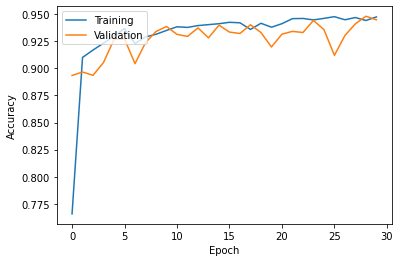

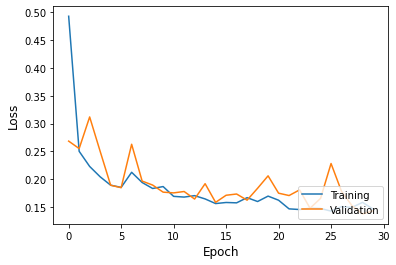

In [84]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_history['accuracy'])
plt.plot(unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_history['loss'])
plt.plot(unet_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')

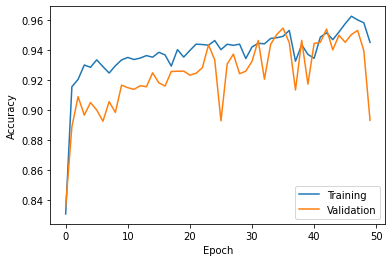

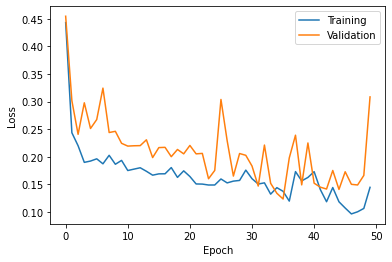

In [85]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

In [86]:
# Scores of each model
unet_score = (score_eval(unet, validation_images, validation_masks))
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

1/1 [==============================] - 0s 32ms/step


In [87]:
# Precision and recall of each model
unet_precision = (precision_eval(unet, validation_images, validation_masks))
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))

unet_recall = (recall_eval(unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

1/1 [==============================] - 0s 32ms/step


In [88]:
# F1-scores of each model
unet_f1_score = (f1_score_eval_basic(unet_precision, unet_recall))
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

# IoU scores of each model
unet_iou = (iou_eval(unet, validation_images, validation_masks))
am_unet_iou = (iou_eval(attention_unet, validation_images, validation_masks))

1/1 [==============================] - 0s 28ms/step


In [89]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_score), np.std(unet_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

U-Net accuracy:  0.9479009628295898 0.05337000819647741
Attention U-Net accuracy:  0.9544612884521484 0.038332060822229036


In [90]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_precision), np.std(unet_precision))
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

U-Net precision:  0.9558588003515582 0.04071524013761342
Attention U-Net precision:  0.9575812477212752 0.03402906460671365


In [91]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_recall), np.std(unet_recall))
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

U-Net recall:  0.9479009628295898 0.05337000819647741
Attention U-Net recall:  0.9544612884521484 0.038332060822229036


In [92]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

# Print IoU eval results for each model
print('U-Net IoU: ', np.mean(unet_iou), np.std(unet_iou))
print('Attention U-Net IoU: ', np.mean(am_unet_iou), np.std(am_unet_iou))

U-Net F1-score:  0.9518632494557714
Attention U-Net F1-score:  0.9560187226031107
U-Net IoU:  0.9048681626038583 0.09349816155741375
Attention U-Net IoU:  0.9159211366050355 0.06799356833809049


## 4-band

### Amazon Data

In [93]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('unet-attention-4d.hdf5')
unet_4d = load_model('unet-4d.hdf5')

unet_4d_history = np.load('unet-4d-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()

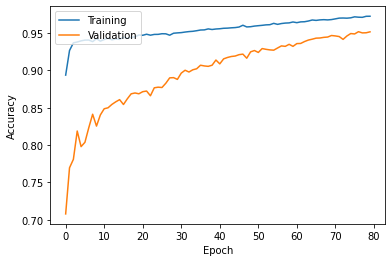

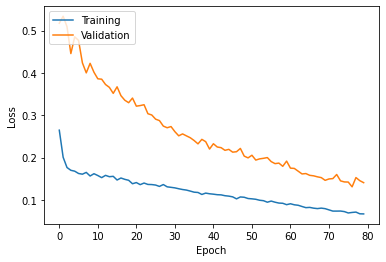

In [94]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_history['accuracy'])
plt.plot(unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_history['loss'])
plt.plot(unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

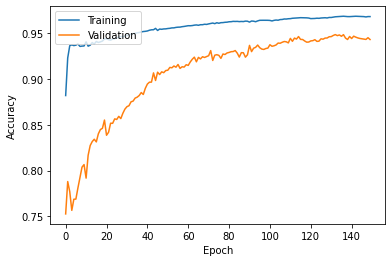

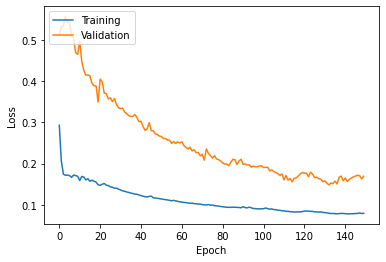

In [95]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [96]:
# Scores of each model
unet_4d_score = (score_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

1/1 [==============================] - 0s 28ms/step


In [97]:
# Precision and recall of each model
unet_4d_precision = (precision_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))

unet_4d_recall = (recall_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

1/1 [==============================] - 0s 30ms/step


In [98]:
# F1-scores of each model
unet_4d_f1_score = (f1_score_eval_basic(unet_4d_precision, unet_4d_recall))
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

# IoU scores of each model
unet_4d_iou = (iou_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_iou = (iou_eval2(attention_unet_4d, validation_images2, validation_masks2))

1/1 [==============================] - 0s 31ms/step


In [99]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_4d_score), np.std(unet_4d_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

U-Net accuracy:  0.951761360168457 0.03952368910851571
Attention U-Net accuracy:  0.9487903594970704 0.0483252458298341


In [100]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_4d_precision), np.std(unet_4d_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

U-Net precision:  0.9604498195121307 0.0285394112053915
Attention U-Net precision:  0.9583980770610155 0.03233998651402656


In [101]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_4d_recall), np.std(unet_4d_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

U-Net recall:  0.951761360168457 0.03952368910851571
Attention U-Net recall:  0.9487903594970704 0.0483252458298341


In [102]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_4d_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

# Print IoU eval results for each model
print('U-Net IoU: ', np.mean(unet_4d_iou), np.std(unet_4d_iou))
print('Attention U-Net IoU: ', np.mean(am_unet_4d_iou), np.std(am_unet_4d_iou))

U-Net F1-score:  0.9560858510879613
Attention U-Net F1-score:  0.9535700181960782
U-Net IoU:  0.9129958236411515 0.06699705823873128
Attention U-Net IoU:  0.9078488843324967 0.0794971202161209


### Amazon on unseen Atlantic data

In [103]:
# Score
unet_amazon_on_atlantic_score = score_eval2(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
unet_amazon_on_atlantic_precision = (precision_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
unet_amazon_on_atlantic_recall = (recall_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(unet_amazon_on_atlantic_precision, unet_amazon_on_atlantic_recall))
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

1/1 [==============================] - 0s 34ms/step


In [104]:
# Print metrics
print('U-Net score: ', np.mean(unet_amazon_on_atlantic_score), np.std(unet_amazon_on_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('U-Net precision: ', np.mean(unet_amazon_on_atlantic_precision), np.std(unet_amazon_on_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('U-Net recall: ', np.mean(unet_amazon_on_atlantic_recall), np.std(unet_amazon_on_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('U-Net F1-score: ', unet_amazon_on_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

U-Net score:  0.8848515510559082 0.09566140419425904
Attention U-Net score:  0.8823853174845377 0.08657215348995408
U-Net precision:  0.9180957816351863 0.04896642136853114
Attention U-Net precision:  0.9118819372108824 0.05219039331879742
U-Net recall:  0.8848515510559082 0.09566140419425904
Attention U-Net recall:  0.8823853174845377 0.08657215348995408
U-Net F1-score:  0.9011671740684938
Attention U-Net F1-score:  0.896891174454195


### Atlantic Data

In [105]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.hdf5')
unet_4d_atlantic = load_model('unet-4d-atlantic.hdf5')

unet_4d_atlantic_history = np.load('unet-4d-atlantic-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_atlantic_history = np.load('unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

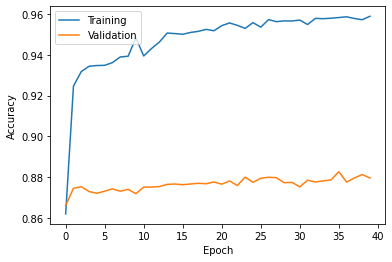

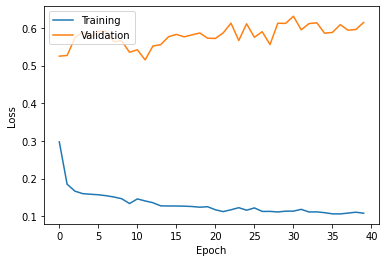

In [106]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_atlantic_history['accuracy'])
plt.plot(unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_atlantic_history['loss'])
plt.plot(unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

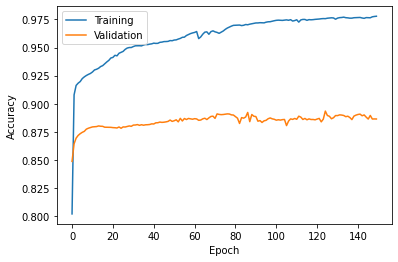

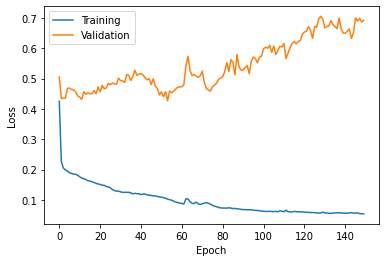

In [107]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [108]:
# Scores of each model
unet_4d_atlantic_score = (score_eval2(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision = (precision_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

unet_4d_atlantic_recall = (recall_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score = (f1_score_eval_basic(unet_4d_atlantic_precision, unet_4d_atlantic_recall))
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

# IoU scores of each model
unet_4d_atlantic_iou = (iou_eval2(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_iou = (iou_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

1/1 [==============================] - 0s 125ms/step


In [109]:
# Print metrics
print('U-Net score: ', np.mean(unet_4d_atlantic_score), np.std(unet_4d_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision), np.std(unet_4d_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall), np.std(unet_4d_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

print('U-Net IoU: ', np.mean(unet_4d_atlantic_iou), np.std(unet_4d_atlantic_iou))
print('Attention U-Net IoU: ', np.mean(am_unet_4d_atlantic_iou), np.std(am_unet_4d_atlantic_iou))

U-Net score:  0.8826895904541016 0.11539552016407582
Attention U-Net score:  0.8934693145751953 0.11121382076254768
U-Net precision:  0.9302820009486195 0.04567568839319466
Attention U-Net precision:  0.9391964226170638 0.039818057244400795
U-Net recall:  0.8826895904541016 0.11539552016407582
Attention U-Net recall:  0.8934693145751953 0.11121382076254768
U-Net F1-score:  0.9058611202934777
Attention U-Net F1-score:  0.9157623967508174
U-Net IoU:  0.8169489800034232 0.15399282206276446
Attention U-Net IoU:  0.8348291648724044 0.14575203351573282


### Atlantic on unseen Amazon data

In [110]:
# Score
unet_atlantic_on_amazon_score = score_eval2(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
unet_atlantic_on_amazon_precision = (precision_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
unet_atlantic_on_amazon_recall = (recall_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(unet_atlantic_on_amazon_precision, unet_atlantic_on_amazon_recall))
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

1/1 [==============================] - 0s 28ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 33ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 36ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 32ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 38ms/step


In [111]:
# Print metrics
print('U-Net score: ', np.mean(unet_atlantic_on_amazon_score), np.std(unet_atlantic_on_amazon_score))
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('U-Net precision: ', np.mean(unet_atlantic_on_amazon_precision), np.std(unet_atlantic_on_amazon_precision))
print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('U-Net recall: ', np.mean(unet_atlantic_on_amazon_recall), np.std(unet_atlantic_on_amazon_recall))
print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('U-Net F1-score: ', unet_atlantic_on_amazon_f1_score)
print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

U-Net score:  0.9208434740702311 0.06011874277833397
Attention U-Net score:  0.9497175852457682 0.041113852351421766
U-Net precision:  0.9389684531913737 0.04252142003732148
Attention U-Net precision:  0.9587880091405255 0.026509823262089945
U-Net recall:  0.9208434740702311 0.06011874277833397
Attention U-Net recall:  0.9497175852457682 0.041113852351421766
U-Net F1-score:  0.9298176442520183
Attention U-Net F1-score:  0.9542312430017751


### Amazon and Atlantic unseen test data

In [112]:
# Amazon trained model on Amazon test data
# Scores of each model
unet_4d_score_test = (score_eval2(unet_4d, test_images2, test_masks2))
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
unet_4d_precision_test = (precision_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

unet_4d_recall_test = (recall_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
unet_4d_f1_score_test = (f1_score_eval_basic(unet_4d_precision_test, unet_4d_recall_test))
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

1/1 [==============================] - 0s 31ms/step


In [113]:
# Atlantic trained model on Atlantic test data
# Scores of each model
unet_4d_atlantic_score_test = (score_eval2(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision_test = (precision_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

unet_4d_atlantic_recall_test = (recall_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(unet_4d_atlantic_precision_test, unet_4d_atlantic_recall_test))
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

1/1 [==============================] - 0s 31ms/step


In [114]:
# Print metrics for Amazon on Amazon Test set
print('U-Net score: ', np.mean(unet_4d_score_test), np.std(unet_4d_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('U-Net precision: ', np.mean(unet_4d_precision_test), np.std(unet_4d_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('U-Net recall: ', np.mean(unet_4d_recall_test), np.std(unet_4d_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('U-Net F1-score: ', unet_4d_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

U-Net score:  0.94940185546875 0.0449302240574146
Attention U-Net score:  0.9374868392944335 0.06858531550416724
U-Net precision:  0.9566344551502904 0.030725187925912525
Attention U-Net precision:  0.949706994780627 0.04285945614869962
U-Net recall:  0.94940185546875 0.0449302240574146
Attention U-Net recall:  0.9374868392944335 0.06858531550416724
U-Net F1-score:  0.9530044329848556
Attention U-Net F1-score:  0.9435573524211645


In [115]:
# Print metrics for Atlantic on Atlantic Test set
print('U-Net score: ', np.mean(unet_4d_atlantic_score_test), np.std(unet_4d_atlantic_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision_test), np.std(unet_4d_atlantic_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall_test), np.std(unet_4d_atlantic_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

U-Net score:  0.8881359100341797 0.11679332648810041
Attention U-Net score:  0.8987215042114258 0.12155413960283042
U-Net precision:  0.9313313341988178 0.04072761134138759
Attention U-Net precision:  0.9417968521772242 0.03886947835661258
U-Net recall:  0.8881359100341797 0.11679332648810041
Attention U-Net recall:  0.8987215042114258 0.12155413960283042
U-Net F1-score:  0.9092208773351137
Attention U-Net F1-score:  0.9197551121533822


## ResNet50-SegNet

In [116]:
# Load ResNet models and history stats
resnet_3d = ResNet50SegNet()
resnet_3d.load_weights('resnet50segnet-3d.hdf5')
resnet_4d_amazon = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_amazon.load_weights('resnet50segnet-4d.hdf5')
resnet_4d_atlantic = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_atlantic.load_weights('resnet50segnet-4d-atlantic.hdf5')

resnet_3d_history = np.load('resnet50segnet-3d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_amazon_history = np.load('resnet50segnet-4d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_atlantic_history = np.load('resnet50segnet-4d-history-atlantic.npy', allow_pickle='TRUE').item()

In [117]:
# Metrics of each model on respective datasets

# Score
resnet_3d_score = (score_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_score = (score_eval2(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_score = (score_eval2(resnet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
resnet_3d_precision = (precision_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_precision = (precision_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_precision = (precision_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

resnet_3d_recall = (recall_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_recall = (recall_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_recall = (recall_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

# F1-score
resnet_3d_f1_score = (f1_score_eval_basic(resnet_3d_precision, resnet_3d_recall))
resnet_4d_amazon_f1_score = (f1_score_eval_basic(resnet_4d_amazon_precision, resnet_4d_amazon_recall))
resnet_4d_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_precision, resnet_4d_atlantic_recall))

1/1 [==============================] - 0s 53ms/step


In [118]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
resnet_4d_amazon_on_atlantic_score = (score_eval2(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_score = (score_eval2(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
resnet_4d_amazon_on_atlantic_precision = (precision_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_precision = (precision_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

resnet_4d_amazon_on_atlantic_recall = (recall_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_recall = (recall_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
resnet_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_recall))
resnet_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_recall))

1/1 [==============================] - 0s 61ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 75ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 67ms/step


In [119]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('ResNet 3-dim: ', np.mean(resnet_3d_score), np.mean(resnet_3d_precision), np.mean(resnet_3d_recall), resnet_3d_f1_score)
print('ResNet 3-dim: ', np.std(resnet_3d_score), np.std(resnet_3d_precision), np.std(resnet_3d_recall), resnet_3d_f1_score)
print('----')
print('ResNet 4-dim Amazon: ', np.mean(resnet_4d_amazon_score), np.mean(resnet_4d_amazon_precision), np.mean(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('ResNet 4-dim Amazon: ', np.std(resnet_4d_amazon_score), np.std(resnet_4d_amazon_precision), np.std(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('----')
print('ResNet 4-dim Atlantic: ', np.mean(resnet_4d_atlantic_score), np.mean(resnet_4d_atlantic_precision), np.mean(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('ResNet 4-dim Atlantic: ', np.std(resnet_4d_atlantic_score), np.std(resnet_4d_atlantic_precision), np.std(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('----')
print('ResNet 4-dim Amazon on Atlantic: ', np.mean(resnet_4d_amazon_on_atlantic_score), np.mean(resnet_4d_amazon_on_atlantic_precision), np.mean(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('ResNet 4-dim Amazon on Atlantic: ', np.std(resnet_4d_amazon_on_atlantic_score), np.std(resnet_4d_amazon_on_atlantic_precision), np.std(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('----')
print('ResNet 4-dim Atlantic on Amazon: ', np.mean(resnet_4d_atlantic_on_amazon_score), np.mean(resnet_4d_atlantic_on_amazon_precision), np.mean(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)
print('ResNet 4-dim Atlantic on Amazon: ', np.std(resnet_4d_atlantic_on_amazon_score), np.std(resnet_4d_atlantic_on_amazon_precision), np.std(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
ResNet 3-dim:  0.9508970260620118 0.9561444613174824 0.9508970260620118 0.9535135242409458
ResNet 3-dim:  0.044494833041061006 0.03658863486586675 0.044494833041061006 0.9535135242409458
----
ResNet 4-dim Amazon:  0.8679681777954101 0.9175694438534768 0.8679681777954101 0.8920798626990348
ResNet 4-dim Amazon:  0.11278786704517747 0.060688666180113364 0.11278786704517747 0.8920798626990348
----
ResNet 4-dim Atlantic:  0.8800629425048828 0.9263780971917374 0.8800629425048828 0.9026267851217044
ResNet 4-dim Atlantic:  0.11060318717252311 0.04469321120117525 0.11060318717252311 0.9026267851217044
----
ResNet 4-dim Amazon on Atlantic:  0.8679706573486328 0.900040379586311 0.8679706573486328 0.8837146642072562
ResNet 4-dim Amazon on Atlantic:  0.08969550222382675 0.055133509066663595 0.08969550222382675 0.8837146642072562
----
ResNet 4-dim Atlantic on Amazon:  0.9181686083475749 0.9373609798936077 0.9181686083475749 0.927665537518084
ResNet 4-dim Atla

### Amazon and Atlantic unseen test datasets

In [120]:
# Amazon trained model on Amazon test data
# Scores of each model
resnet_4d_score_test = (score_eval2(resnet_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
resnet_4d_precision_test = (precision_eval(resnet_4d_amazon, test_images2, test_masks2))
resnet_4d_recall_test = (recall_eval(resnet_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
resnet_4d_f1_score_test = (f1_score_eval_basic(resnet_4d_precision_test, resnet_4d_recall_test))

1/1 [==============================] - 0s 57ms/step


In [121]:
# Atlantic trained model on Atlantic test data
# Scores of each model
resnet_4d_atlantic_score_test = (score_eval2(resnet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
resnet_4d_atlantic_precision_test = (precision_eval(resnet_4d_atlantic, test_images3, test_masks3))
resnet_4d_atlantic_recall_test = (recall_eval(resnet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
resnet_4d_atlantic_f1_score_test = (f1_score_eval_basic(resnet_4d_atlantic_precision_test, resnet_4d_atlantic_recall_test))

1/1 [==============================] - 0s 53ms/step


In [122]:
# Print metrics for Amazon on Amazon Test set
print('ResNet score: ', np.mean(resnet_4d_score_test), np.std(resnet_4d_score_test))
print('ResNet precision: ', np.mean(resnet_4d_precision_test), np.std(resnet_4d_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_recall_test), np.std(resnet_4d_recall_test))
print('ResNet F1-score: ', resnet_4d_f1_score_test)

ResNet score:  0.8632015228271485 0.1373730215619639
ResNet precision:  0.9038823198957345 0.07953768728536538
ResNet recall:  0.8632015228271485 0.1373730215619639
ResNet F1-score:  0.8830736562995004


In [123]:
# Print metrics for Atlantic on Atlantic Test set
print('ResNet score: ', np.mean(resnet_4d_atlantic_score_test), np.std(resnet_4d_atlantic_score_test))
print('ResNet precision: ', np.mean(resnet_4d_atlantic_precision_test), np.std(resnet_4d_atlantic_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_atlantic_recall_test), np.std(resnet_4d_atlantic_recall_test))
print('ResNet F1-score: ', resnet_4d_atlantic_f1_score_test)

ResNet score:  0.8873722076416015 0.10934529997628847
ResNet precision:  0.9274977309574501 0.038683055760215614
ResNet recall:  0.8873722076416015 0.10934529997628847
ResNet F1-score:  0.9069913954689368


## FCN32-VGG16

In [124]:
# Import models
fcn32_3d = load_model('fcn32-3d.hdf5')
fcn32_4d_amazon = load_model('fcn32-4d.hdf5')
fcn32_4d_atlantic = load_model('fcn32-4d-atlantic.hdf5')

fcn32_3d_history = np.load('fcn32-3d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_amazon_history = np.load('fcn32-4d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_atlantic_history = np.load('fcn32-4d-atlantic-history.npy', allow_pickle='TRUE').item()

In [125]:
# Metrics of each model on respective datasets

# Score
fcn32_3d_score = (score_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_score = (score_eval2(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_score = (score_eval2(fcn32_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
fcn32_3d_precision = (precision_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_precision = (precision_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_precision = (precision_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

fcn32_3d_recall = (recall_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_recall = (recall_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_recall = (recall_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

# F1-score
fcn32_3d_f1_score = (f1_score_eval_basic(fcn32_3d_precision, fcn32_3d_recall))
fcn32_4d_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_precision, fcn32_4d_amazon_recall))
fcn32_4d_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_precision, fcn32_4d_atlantic_recall))

1/1 [==============================] - 0s 30ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 29ms/step


In [126]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
fcn32_4d_amazon_on_atlantic_score = (score_eval2(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_score = (score_eval2(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
fcn32_4d_amazon_on_atlantic_precision = (precision_eval(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_precision = (precision_eval(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

fcn32_4d_amazon_on_atlantic_recall = (recall_eval(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_recall = (recall_eval(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
fcn32_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_recall))
fcn32_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_recall))

1/1 [==============================] - 0s 30ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 39ms/step


In [127]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('FCN32 3-dim: ', np.mean(fcn32_3d_score), np.mean(fcn32_3d_precision), np.mean(fcn32_3d_recall), fcn32_3d_f1_score)
print('FCN32 3-dim: ', np.std(fcn32_3d_score), np.std(fcn32_3d_precision), np.std(fcn32_3d_recall), fcn32_3d_f1_score)
print('----')
print('FCN32 4-dim Amazon: ', np.mean(fcn32_4d_amazon_score), np.mean(fcn32_4d_amazon_precision), np.mean(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('FCN32 4-dim Amazon: ', np.std(fcn32_4d_amazon_score), np.std(fcn32_4d_amazon_precision), np.std(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('----')
print('FCN32 4-dim Atlantic: ', np.mean(fcn32_4d_atlantic_score), np.mean(fcn32_4d_atlantic_precision), np.mean(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('FCN32 4-dim Atlantic: ', np.std(fcn32_4d_atlantic_score), np.std(fcn32_4d_atlantic_precision), np.std(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('----')
print('FCN32 4-dim Amazon on Atlantic: ', np.mean(fcn32_4d_amazon_on_atlantic_score), np.mean(fcn32_4d_amazon_on_atlantic_precision), np.mean(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('FCN32 4-dim Amazon on Atlantic: ', np.std(fcn32_4d_amazon_on_atlantic_score), np.std(fcn32_4d_amazon_on_atlantic_precision), np.std(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('----')
print('FCN32 4-dim Atlantic on Amazon: ', np.mean(fcn32_4d_atlantic_on_amazon_score), np.mean(fcn32_4d_atlantic_on_amazon_precision), np.mean(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)
print('FCN32 4-dim Atlantic on Amazon: ', np.std(fcn32_4d_atlantic_on_amazon_score), np.std(fcn32_4d_atlantic_on_amazon_precision), np.std(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
FCN32 3-dim:  0.8993587493896484 0.9027480979342094 0.8993587493896484 0.9010502363693514
FCN32 3-dim:  0.07499725664314046 0.07643075265908726 0.07499725664314046 0.9010502363693514
----
FCN32 4-dim Amazon:  0.9106870651245117 0.9137714112819603 0.9106870651245117 0.9122266310758768
FCN32 4-dim Amazon:  0.051115457223881715 0.04528107033807835 0.051115457223881715 0.9122266310758768
----
FCN32 4-dim Atlantic:  0.8044480895996093 0.8259596225596879 0.8044480895996093 0.8150619449347118
FCN32 4-dim Atlantic:  0.07491620160508164 0.055117280254716725 0.07491620160508164 0.8150619449347118
----
FCN32 4-dim Amazon on Atlantic:  0.7943352699279785 0.8185716509851542 0.7943352699279785 0.8062713662020462
FCN32 4-dim Amazon on Atlantic:  0.10254034537251594 0.06792222489537737 0.10254034537251594 0.8062713662020462
----
FCN32 4-dim Atlantic on Amazon:  0.8653162638346354 0.8983022604867749 0.8653162638346354 0.8815007838928343
FCN32 4-dim Atlantic on A

### Amazon and Atlantic unseen test datasets

In [128]:
# Amazon trained model on Amazon test data
# Scores of each model
fcn32_4d_score_test = (score_eval2(fcn32_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
fcn32_4d_precision_test = (precision_eval(fcn32_4d_amazon, test_images2, test_masks2))
fcn32_4d_recall_test = (recall_eval(fcn32_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
fcn32_4d_f1_score_test = (f1_score_eval_basic(fcn32_4d_precision_test, fcn32_4d_recall_test))

1/1 [==============================] - 0s 35ms/step


In [129]:
# Atlantic trained model on Atlantic test data
# Scores of each model
fcn32_4d_atlantic_score_test = (score_eval2(fcn32_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
fcn32_4d_atlantic_precision_test = (precision_eval(fcn32_4d_atlantic, test_images3, test_masks3))
fcn32_4d_atlantic_recall_test = (recall_eval(fcn32_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
fcn32_4d_atlantic_f1_score_test = (f1_score_eval_basic(fcn32_4d_atlantic_precision_test, fcn32_4d_atlantic_recall_test))

1/1 [==============================] - 0s 26ms/step


In [130]:
# Print metrics for Amazon on Amazon Test set
print('FCN32 score: ', np.mean(fcn32_4d_score_test), np.std(fcn32_4d_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_precision_test), np.std(fcn32_4d_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_recall_test), np.std(fcn32_4d_recall_test))
print('FCN32 F1-score: ', fcn32_4d_f1_score_test)

FCN32 score:  0.906735610961914 0.04414497039823232
FCN32 precision:  0.9091651615201426 0.03855249500020928
FCN32 recall:  0.906735610961914 0.04414497039823232
FCN32 F1-score:  0.9079487609551085


In [131]:
# Print metrics for Atlantic on Atlantic Test set
print('FCN32 score: ', np.mean(fcn32_4d_atlantic_score_test), np.std(fcn32_4d_atlantic_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_atlantic_precision_test), np.std(fcn32_4d_atlantic_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_atlantic_recall_test), np.std(fcn32_4d_atlantic_recall_test))
print('FCN32 F1-score: ', fcn32_4d_atlantic_f1_score_test)

FCN32 score:  0.7944475173950195 0.07667827683678388
FCN32 precision:  0.814664979683385 0.05541261418409847
FCN32 recall:  0.7944475173950195 0.07667827683678388
FCN32 F1-score:  0.8044292388422035


## ResUNet

In [132]:
# Load ResUNet models and history stats
# Import models
resunet_3d = res_unet(512, [64, 128, 256, 512], 3, 3, 1)
resunet_4d_amazon = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
resunet_4d_atlantic = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
resunet_3d.load_weights('resunet-3d.hdf5')
resunet_4d_amazon.load_weights('resunet-4d.hdf5')
resunet_4d_atlantic.load_weights('resunet-4d-atlantic.hdf5')

resunet_3d_history = np.load('resunet-3d-history.npy', allow_pickle='TRUE').item()
resunet_4d_amazon_history = np.load('resunet-4d-history.npy', allow_pickle='TRUE').item()
resunet_4d_atlantic_history = np.load('resunet-4d-history-atlantic.npy', allow_pickle='TRUE').item()

In [133]:
# Metrics of each model on respective datasets

# Score
resunet_3d_score = (score_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_score = (score_eval2(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_score = (score_eval2(resunet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
resunet_3d_precision = (precision_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_precision = (precision_eval(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_precision = (precision_eval(resunet_4d_atlantic, validation_images3, validation_masks3))

resunet_3d_recall = (recall_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_recall = (recall_eval(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_recall = (recall_eval(resunet_4d_atlantic, validation_images3, validation_masks3))

# F1-score
resunet_3d_f1_score = (f1_score_eval_basic(resunet_3d_precision, resnet_3d_recall))
resunet_4d_amazon_f1_score = (f1_score_eval_basic(resunet_4d_amazon_precision, resnet_4d_amazon_recall))
resunet_4d_atlantic_f1_score = (f1_score_eval_basic(resunet_4d_atlantic_precision, resnet_4d_atlantic_recall))

1/1 [==============================] - 0s 37ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 39ms/step


In [134]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
resunet_4d_amazon_on_atlantic_score = (score_eval2(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resunet_4d_atlantic_on_amazon_score = (score_eval2(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
resunet_4d_amazon_on_atlantic_precision = (precision_eval(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resunet_4d_atlantic_on_amazon_precision = (precision_eval(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

resunet_4d_amazon_on_atlantic_recall = (recall_eval(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resunet_4d_atlantic_on_amazon_recall = (recall_eval(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
resunet_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(resunet_4d_amazon_on_atlantic_precision, resunet_4d_amazon_on_atlantic_recall))
resunet_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(resunet_4d_atlantic_on_amazon_precision, resunet_4d_atlantic_on_amazon_recall))

1/1 [==============================] - 0s 30ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 35ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 36ms/step


In [135]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('ResUNet 3-dim: ', np.mean(resunet_3d_score), np.mean(resunet_3d_precision), np.mean(resunet_3d_recall), resunet_3d_f1_score)
print('ResUNet 3-dim: ', np.std(resunet_3d_score), np.std(resunet_3d_precision), np.std(resunet_3d_recall), resunet_3d_f1_score)
print('----')
print('ResUNet 4-dim Amazon: ', np.mean(resunet_4d_amazon_score), np.mean(resunet_4d_amazon_precision), np.mean(resunet_4d_amazon_recall), resunet_4d_amazon_f1_score)
print('ResUNet 4-dim Amazon: ', np.std(resunet_4d_amazon_score), np.std(resunet_4d_amazon_precision), np.std(resunet_4d_amazon_recall), resunet_4d_amazon_f1_score)
print('----')
print('ResUNet 4-dim Atlantic: ', np.mean(resunet_4d_atlantic_score), np.mean(resunet_4d_atlantic_precision), np.mean(resunet_4d_atlantic_recall), resunet_4d_atlantic_f1_score)
print('ResUNet 4-dim Atlantic: ', np.std(resunet_4d_atlantic_score), np.std(resunet_4d_atlantic_precision), np.std(resunet_4d_atlantic_recall), resunet_4d_atlantic_f1_score)
print('----')
print('ResUNet 4-dim Amazon on Atlantic: ', np.mean(resunet_4d_amazon_on_atlantic_score), np.mean(resunet_4d_amazon_on_atlantic_precision), np.mean(resunet_4d_amazon_on_atlantic_recall), resunet_4d_amazon_on_atlantic_f1_score)
print('ResUNet 4-dim Amazon on Atlantic: ', np.std(resunet_4d_amazon_on_atlantic_score), np.std(resunet_4d_amazon_on_atlantic_precision), np.std(resunet_4d_amazon_on_atlantic_recall), resunet_4d_amazon_on_atlantic_f1_score)
print('----')
print('ResUNet 4-dim Atlantic on Amazon: ', np.mean(resunet_4d_atlantic_on_amazon_score), np.mean(resunet_4d_atlantic_on_amazon_precision), np.mean(resunet_4d_atlantic_on_amazon_recall), resunet_4d_atlantic_on_amazon_f1_score)
print('ResUNet 4-dim Atlantic on Amazon: ', np.std(resunet_4d_atlantic_on_amazon_score), np.std(resunet_4d_atlantic_on_amazon_precision), np.std(resunet_4d_atlantic_on_amazon_recall), resunet_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
ResUNet 3-dim:  0.9475332260131836 0.9557978579946249 0.9475332260131836 0.9533411436546686
ResUNet 3-dim:  0.054749960057841204 0.041384268116678086 0.054749960057841204 0.9533411436546686
----
ResUNet 4-dim Amazon:  0.9364933395385742 0.9484345350344416 0.9364933395385742 0.9064190328691656
ResUNet 4-dim Amazon:  0.0474063641148429 0.03589498960356134 0.0474063641148429 0.9064190328691656
----
ResUNet 4-dim Atlantic:  0.8861356735229492 0.9324555072003381 0.8861356735229492 0.9055019964680349
ResUNet 4-dim Atlantic:  0.11406854491989714 0.04403525084556954 0.11406854491989714 0.9055019964680349
----
ResUNet 4-dim Amazon on Atlantic:  0.8727608362833659 0.923698028605735 0.8727608362833659 0.8975072902312228
ResUNet 4-dim Amazon on Atlantic:  0.11645460412026716 0.044183098892625755 0.11645460412026716 0.8975072902312228
----
ResUNet 4-dim Atlantic on Amazon:  0.9227339744567871 0.9401116699892552 0.9227339744567871 0.9313417676539215
ResUNet 4

### Amazon and Atlantic unseen test datasets

In [136]:
# Amazon trained model on Amazon test data
# Scores of each model
resunet_4d_score_test = (score_eval2(resunet_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
resunet_4d_precision_test = (precision_eval(resunet_4d_amazon, test_images2, test_masks2))
resunet_4d_recall_test = (recall_eval(resunet_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
resunet_4d_f1_score_test = (f1_score_eval_basic(resunet_4d_precision_test, resunet_4d_recall_test))

1/1 [==============================] - 0s 33ms/step


/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 33ms/step


In [137]:
# Atlantic trained model on Atlantic test data
# Scores of each model
resunet_4d_atlantic_score_test = (score_eval2(resunet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
resunet_4d_atlantic_precision_test = (precision_eval(resunet_4d_atlantic, test_images3, test_masks3))
resunet_4d_atlantic_recall_test = (recall_eval(resunet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
resunet_4d_atlantic_f1_score_test = (f1_score_eval_basic(resunet_4d_atlantic_precision_test, resunet_4d_atlantic_recall_test))

1/1 [==============================] - 0s 32ms/step


In [138]:
# Print metrics for Amazon on Amazon Test set
print('ResUNet score: ', np.mean(resunet_4d_score_test), np.std(resunet_4d_score_test))
print('ResUNet precision: ', np.mean(resunet_4d_precision_test), np.std(resunet_4d_precision_test))
print('ResUNet recall: ', np.mean(resunet_4d_recall_test), np.std(resunet_4d_recall_test))
print('ResUNet F1-score: ', resunet_4d_f1_score_test)

ResUNet score:  0.9297449111938476 0.0815088035491
ResUNet precision:  0.9447612640813254 0.05159628183526663
ResUNet recall:  0.9297449111938476 0.0815088035491
ResUNet F1-score:  0.9371929409021381


In [139]:
# Print metrics for Atlantic on Atlantic Test set
print('ResUNet score: ', np.mean(resunet_4d_atlantic_score_test), np.std(resunet_4d_atlantic_score_test))
print('ResUNet precision: ', np.mean(resunet_4d_atlantic_precision_test), np.std(resunet_4d_atlantic_precision_test))
print('ResUNet recall: ', np.mean(resunet_4d_atlantic_recall_test), np.std(resunet_4d_atlantic_recall_test))
print('ResUNet F1-score: ', resunet_4d_atlantic_f1_score_test)

ResUNet score:  0.8937101364135742 0.11436560482062011
ResUNet precision:  0.9346859055027806 0.039508654374799064
ResUNet recall:  0.8937101364135742 0.11436560482062011
ResUNet F1-score:  0.9137388716234708


# Produce metric datasets for export

## RGB data

In [150]:
scores_3d = [unet_score, am_unet_score, resnet_3d_score, fcn32_3d_score, resunet_3d_score]
precision_3d = [unet_precision, am_unet_precision, resnet_3d_precision, fcn32_3d_precision, resunet_3d_precision]
recall_3d = [unet_recall, am_unet_recall, resnet_3d_recall, fcn32_3d_recall, resunet_3d_recall]
f1_scores_3d = [unet_f1_score, am_unet_f1_score, resnet_3d_f1_score, fcn32_3d_f1_score, resunet_3d_f1_score]

# Calculate IoU for all models if not already calculated
if 'resnet_3d_iou' not in locals():
    resnet_3d_iou = (iou_eval(resnet_3d, validation_images, validation_masks))
if 'fcn32_3d_iou' not in locals():
    fcn32_3d_iou = (iou_eval(fcn32_3d, validation_images, validation_masks))
if 'resunet_3d_iou' not in locals():
    resunet_3d_iou = (iou_eval(resunet_3d, validation_images, validation_masks))

iou_3d = [unet_iou, am_unet_iou, resnet_3d_iou, fcn32_3d_iou, resunet_3d_iou]

import pandas as pd
metrics_3d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_3d],
              'precision': [np.mean(n) for n in precision_3d],
              'recall': [np.mean(n) for n in recall_3d],
              'f1_score': [np.mean(n) for n in f1_scores_3d],
              'iou': [np.mean(n) for n in iou_3d],
              'accuracy_std': [np.std(n) for n in scores_3d],
              'precision_std': [np.std(n) for n in precision_3d],
              'recall_std': [np.std(n) for n in recall_3d],
              'iou_std': [np.std(n) for n in iou_3d]
              }
metrics_3d = pd.DataFrame(metrics_3d)
metrics_3d.to_csv('metrics_3d.csv')

## 4-band Amazon data

In [141]:
scores_4d = [unet_4d_score, am_unet_4d_score, resnet_4d_amazon_score, fcn32_4d_amazon_score, resunet_4d_amazon_score]
precision_4d = [unet_4d_precision, am_unet_4d_precision, resnet_4d_amazon_precision, fcn32_4d_amazon_precision, resunet_4d_amazon_precision]
recall_4d = [unet_4d_recall, am_unet_4d_recall, resnet_4d_amazon_recall, fcn32_4d_amazon_recall, resunet_4d_amazon_recall]
f1_scores_4d = [unet_4d_f1_score, am_unet_4d_f1_score, resnet_4d_amazon_f1_score, fcn32_4d_amazon_f1_score, resunet_4d_amazon_f1_score]

# Calculate IoU for all models if not already calculated
if 'resnet_4d_amazon_iou' not in locals():
    resnet_4d_amazon_iou = (iou_eval2(resnet_4d_amazon, validation_images2, validation_masks2))
if 'fcn32_4d_amazon_iou' not in locals():
    fcn32_4d_amazon_iou = (iou_eval2(fcn32_4d_amazon, validation_images2, validation_masks2))
if 'resunet_4d_amazon_iou' not in locals():
    resunet_4d_amazon_iou = (iou_eval2(resunet_4d_amazon, validation_images2, validation_masks2))

iou_4d = [unet_4d_iou, am_unet_4d_iou, resnet_4d_amazon_iou, fcn32_4d_amazon_iou, resunet_4d_amazon_iou]

metrics_4d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'iou': [np.mean(n) for n in iou_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d],
              'iou_std': [np.std(n) for n in iou_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_4d_amazon.csv')

1/1 [==============================] - 0s 55ms/step


## 4-band Atlantic Forest data

In [142]:
scores_4d_atl = [unet_4d_atlantic_score, am_unet_4d_atlantic_score, resnet_4d_atlantic_score, fcn32_4d_atlantic_score, resunet_4d_atlantic_score]
precision_4d_atl = [unet_4d_atlantic_precision, am_unet_4d_atlantic_precision, resnet_4d_atlantic_precision, fcn32_4d_atlantic_precision, resunet_4d_atlantic_precision]
recall_4d_atl = [unet_4d_atlantic_recall, am_unet_4d_atlantic_recall, resnet_4d_atlantic_recall, fcn32_4d_atlantic_recall, resunet_4d_atlantic_recall]
f1_scores_4d_atl = [unet_4d_atlantic_f1_score, am_unet_4d_atlantic_f1_score, resnet_4d_atlantic_f1_score, fcn32_4d_atlantic_f1_score, resunet_4d_atlantic_f1_score]

# Calculate IoU for all models if not already calculated
if 'resnet_4d_atlantic_iou' not in locals():
    resnet_4d_atlantic_iou = (iou_eval2(resnet_4d_atlantic, validation_images3, validation_masks3))
if 'fcn32_4d_atlantic_iou' not in locals():
    fcn32_4d_atlantic_iou = (iou_eval2(fcn32_4d_atlantic, validation_images3, validation_masks3))
if 'resunet_4d_atlantic_iou' not in locals():
    resunet_4d_atlantic_iou = (iou_eval2(resunet_4d_atlantic, validation_images3, validation_masks3))

iou_4d_atl = [unet_4d_atlantic_iou, am_unet_4d_atlantic_iou, resnet_4d_atlantic_iou, fcn32_4d_atlantic_iou, resunet_4d_atlantic_iou]

metrics_4d_atl = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'iou': [np.mean(n) for n in iou_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl],
              'iou_std': [np.std(n) for n in iou_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_4d_atlantic_forest.csv')

1/1 [==============================] - 0s 36ms/step


## Test set data

In [143]:
scores_4d_test = [unet_4d_score_test, am_unet_4d_score_test, resnet_4d_score_test, fcn32_4d_score_test, resunet_4d_score_test]
precision_4d_test = [unet_4d_precision_test, am_unet_4d_precision_test, resnet_4d_precision_test, fcn32_4d_precision_test, resunet_4d_precision_test]
recall_4d_test = [unet_4d_recall_test, am_unet_4d_recall_test, resnet_4d_recall_test, fcn32_4d_recall_test, resunet_4d_recall_test]
f1_scores_4d_test = [unet_4d_f1_score_test, am_unet_4d_f1_score_test, resnet_4d_f1_score_test, fcn32_4d_f1_score_test, resunet_4d_f1_score_test]

# Calculate IoU for all models on test set if not already calculated
if 'unet_4d_iou_test' not in locals():
    unet_4d_iou_test = (iou_eval2(unet_4d, test_images2, test_masks2))
if 'am_unet_4d_iou_test' not in locals():
    am_unet_4d_iou_test = (iou_eval2(attention_unet_4d, test_images2, test_masks2))
if 'resnet_4d_iou_test' not in locals():
    resnet_4d_iou_test = (iou_eval2(resnet_4d_amazon, test_images2, test_masks2))
if 'fcn32_4d_iou_test' not in locals():
    fcn32_4d_iou_test = (iou_eval2(fcn32_4d_amazon, test_images2, test_masks2))
if 'resunet_4d_iou_test' not in locals():
    resunet_4d_iou_test = (iou_eval2(resunet_4d_amazon, test_images2, test_masks2))

iou_4d_test = [unet_4d_iou_test, am_unet_4d_iou_test, resnet_4d_iou_test, fcn32_4d_iou_test, resunet_4d_iou_test]

metrics_4d_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'iou': [np.mean(n) for n in iou_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test],
              'iou_std': [np.std(n) for n in iou_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_4d_amazon_test.csv')

1/1 [==============================] - 0s 35ms/step


In [144]:
scores_4d_atl_test = [unet_4d_atlantic_score_test, am_unet_4d_atlantic_score_test, resnet_4d_atlantic_score_test, fcn32_4d_atlantic_score_test, resunet_4d_atlantic_score_test]
precision_4d_atl_test = [unet_4d_atlantic_precision_test, am_unet_4d_atlantic_precision_test, resnet_4d_atlantic_precision_test, fcn32_4d_atlantic_precision_test, resunet_4d_atlantic_precision_test]
recall_4d_atl_test = [unet_4d_atlantic_recall_test, am_unet_4d_atlantic_recall_test, resnet_4d_atlantic_recall_test, fcn32_4d_atlantic_recall_test, resunet_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [unet_4d_atlantic_f1_score_test, am_unet_4d_atlantic_f1_score_test, resnet_4d_atlantic_f1_score_test, fcn32_4d_atlantic_f1_score_test, resunet_4d_atlantic_f1_score_test]

# Calculate IoU for all models on test set if not already calculated
if 'unet_4d_atlantic_iou_test' not in locals():
    unet_4d_atlantic_iou_test = (iou_eval2(unet_4d_atlantic, test_images3, test_masks3))
if 'am_unet_4d_atlantic_iou_test' not in locals():
    am_unet_4d_atlantic_iou_test = (iou_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))
if 'resnet_4d_atlantic_iou_test' not in locals():
    resnet_4d_atlantic_iou_test = (iou_eval2(resnet_4d_atlantic, test_images3, test_masks3))
if 'fcn32_4d_atlantic_iou_test' not in locals():
    fcn32_4d_atlantic_iou_test = (iou_eval2(fcn32_4d_atlantic, test_images3, test_masks3))
if 'resunet_4d_atlantic_iou_test' not in locals():
    resunet_4d_atlantic_iou_test = (iou_eval2(resunet_4d_atlantic, test_images3, test_masks3))

iou_4d_atl_test = [unet_4d_atlantic_iou_test, am_unet_4d_atlantic_iou_test, resnet_4d_atlantic_iou_test, fcn32_4d_atlantic_iou_test, resunet_4d_atlantic_iou_test]

metrics_4d_atl_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'iou': [np.mean(n) for n in iou_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test],
              'iou_std': [np.std(n) for n in iou_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_4d_atlantic_forest_test.csv')

1/1 [==============================] - 0s 40ms/step


## Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [145]:
scores_amazon_on_atlantic = [unet_amazon_on_atlantic_score, am_unet_amazon_on_atlantic_score, resnet_4d_amazon_on_atlantic_score, fcn32_4d_amazon_on_atlantic_score, resunet_4d_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_precision, resunet_4d_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [unet_amazon_on_atlantic_recall, am_unet_amazon_on_atlantic_recall, resnet_4d_amazon_on_atlantic_recall, fcn32_4d_amazon_on_atlantic_recall, resunet_4d_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [unet_amazon_on_atlantic_f1_score, am_unet_amazon_on_atlantic_f1_score, resnet_4d_amazon_on_atlantic_f1_score, fcn32_4d_amazon_on_atlantic_f1_score, resunet_4d_amazon_on_atlantic_f1_score]

# Calculate IoU for all models if not already calculated
if 'unet_amazon_on_atlantic_iou' not in locals():
    unet_amazon_on_atlantic_iou = (iou_eval2(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
if 'am_unet_amazon_on_atlantic_iou' not in locals():
    am_unet_amazon_on_atlantic_iou = (iou_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
if 'resnet_4d_amazon_on_atlantic_iou' not in locals():
    resnet_4d_amazon_on_atlantic_iou = (iou_eval2(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
if 'fcn32_4d_amazon_on_atlantic_iou' not in locals():
    fcn32_4d_amazon_on_atlantic_iou = (iou_eval2(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
if 'resunet_4d_amazon_on_atlantic_iou' not in locals():
    resunet_4d_amazon_on_atlantic_iou = (iou_eval2(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))

iou_amazon_on_atlantic = [unet_amazon_on_atlantic_iou, am_unet_amazon_on_atlantic_iou, resnet_4d_amazon_on_atlantic_iou, fcn32_4d_amazon_on_atlantic_iou, resunet_4d_amazon_on_atlantic_iou]

metrics_4d_amazon_on_atlantic = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'iou': [np.mean(n) for n in iou_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic],
              'iou_std': [np.std(n) for n in iou_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_4d_amazon_on_atlantic.csv')

1/1 [==============================] - 0s 33ms/step


In [146]:
scores_atlantic_on_amazon = [unet_atlantic_on_amazon_score, am_unet_atlantic_on_amazon_score, resnet_4d_atlantic_on_amazon_score, fcn32_4d_atlantic_on_amazon_score, resunet_4d_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_precision, resunet_4d_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [unet_atlantic_on_amazon_recall, am_unet_atlantic_on_amazon_recall, resnet_4d_atlantic_on_amazon_recall, fcn32_4d_atlantic_on_amazon_recall, resunet_4d_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [unet_atlantic_on_amazon_f1_score, am_unet_atlantic_on_amazon_f1_score, resnet_4d_atlantic_on_amazon_f1_score, fcn32_4d_atlantic_on_amazon_f1_score, resunet_4d_atlantic_on_amazon_f1_score]

# Calculate IoU for all models if not already calculated
if 'unet_atlantic_on_amazon_iou' not in locals():
    unet_atlantic_on_amazon_iou = (iou_eval2(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
if 'am_unet_atlantic_on_amazon_iou' not in locals():
    am_unet_atlantic_on_amazon_iou = (iou_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
if 'resnet_4d_atlantic_on_amazon_iou' not in locals():
    resnet_4d_atlantic_on_amazon_iou = (iou_eval2(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
if 'fcn32_4d_atlantic_on_amazon_iou' not in locals():
    fcn32_4d_atlantic_on_amazon_iou = (iou_eval2(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
if 'resunet_4d_atlantic_on_amazon_iou' not in locals():
    resunet_4d_atlantic_on_amazon_iou = (iou_eval2(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

iou_atlantic_on_amazon = [unet_atlantic_on_amazon_iou, am_unet_atlantic_on_amazon_iou, resnet_4d_atlantic_on_amazon_iou, fcn32_4d_atlantic_on_amazon_iou, resunet_4d_atlantic_on_amazon_iou]

metrics_4d_atlantic_on_amazon = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'iou': [np.mean(n) for n in iou_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon],
              'iou_std': [np.std(n) for n in iou_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_4d_atlantic_on_amazon.csv')

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


/tmp/ipykernel_852/888235886.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0, 0.9, 0.99])


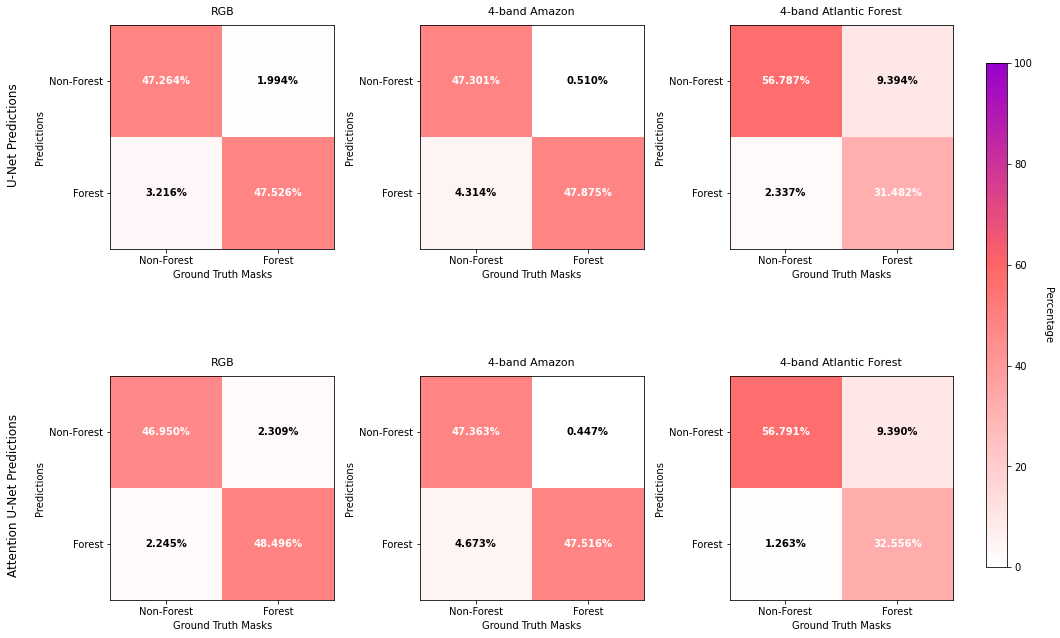

<Figure size 432x288 with 0 Axes>

In [147]:
# 绘制混淆矩阵图 - U-Net和Attention U-Net在三个数据集上的混淆矩阵
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 定义函数来计算混淆矩阵（百分比形式）
def compute_confusion_matrix_percentage(model, images, masks, is_4d=False):
    """
    计算混淆矩阵并返回百分比形式（相对于总像素数）
    """
    all_predictions = []
    all_ground_truth = []
    
    for i in range(len(images)):
        if is_4d:
            pred = model.predict(images[i].reshape(1, 512, 512, 4))
        else:
            pred = model.predict(images[i].reshape(1, 512, 512, 3))
        pred = np.round(pred).flatten()
        gt = masks[i].flatten()
        
        all_predictions.extend(pred)
        all_ground_truth.extend(gt)
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_ground_truth, all_predictions, labels=[0, 1])
    
    # 转换为百分比（相对于总像素数）
    total_pixels = cm.sum()
    cm_percent = cm.astype('float') / total_pixels * 100
    
    
    return cm_percent

# 计算所有混淆矩阵
# RGB数据集
cm_unet_rgb = compute_confusion_matrix_percentage(unet, validation_images, validation_masks, is_4d=False)
cm_am_unet_rgb = compute_confusion_matrix_percentage(attention_unet, validation_images, validation_masks, is_4d=False)

# 4-band Amazon数据集
cm_unet_amazon = compute_confusion_matrix_percentage(unet_4d, validation_images2, validation_masks2, is_4d=True)
cm_am_unet_amazon = compute_confusion_matrix_percentage(attention_unet_4d, validation_images2, validation_masks2, is_4d=True)

# 4-band Atlantic Forest数据集
cm_unet_atlantic = compute_confusion_matrix_percentage(unet_4d_atlantic, validation_images3, validation_masks3, is_4d=True)
cm_am_unet_atlantic = compute_confusion_matrix_percentage(attention_unet_4d_atlantic, validation_images3, validation_masks3, is_4d=True)

# 创建图形
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 定义标签
labels = ['Non-Forest', 'Forest']

# 定义颜色映射（从浅粉到深紫）
from matplotlib.colors import LinearSegmentedColormap
colors = ['#ffffff', '#ffcccc', '#ff9999', '#ff6666', '#cc3399', '#9900cc']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# 绘制U-Net的混淆矩阵（第一行）
unet_cms = [cm_unet_rgb, cm_unet_amazon, cm_unet_atlantic]
unet_titles = ['RGB', '4-band Amazon', '4-band Atlantic Forest']

for i, (cm, title) in enumerate(zip(unet_cms, unet_titles)):
    ax = axes[0, i]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=100)
    ax.set(xticks=np.arange(2), yticks=np.arange(2),
           xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Ground Truth Masks', fontsize=10)
    ax.set_ylabel('Predictions', fontsize=10)
    ax.set_title(title, fontsize=11, pad=10)
    
    # 添加百分比文本
    thresh = cm.max() / 2.
    for j in range(2):
        for k in range(2):
            text = ax.text(k, j, f'{cm[j, k]:.3f}%',
                          ha="center", va="center",
                          color="white" if cm[j, k] > thresh else "black",
                          fontsize=10, weight='bold')

# 绘制Attention U-Net的混淆矩阵（第二行）
am_unet_cms = [cm_am_unet_rgb, cm_am_unet_amazon, cm_am_unet_atlantic]

for i, (cm, title) in enumerate(zip(am_unet_cms, unet_titles)):
    ax = axes[1, i]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=100)
    ax.set(xticks=np.arange(2), yticks=np.arange(2),
           xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Ground Truth Masks', fontsize=10)
    ax.set_ylabel('Predictions', fontsize=10)
    ax.set_title(title, fontsize=11, pad=10)
    
    # 添加百分比文本
    thresh = cm.max() / 2.
    for j in range(2):
        for k in range(2):
            text = ax.text(k, j, f'{cm[j, k]:.3f}%',
                          ha="center", va="center",
                          color="white" if cm[j, k] > thresh else "black",
                          fontsize=10, weight='bold')

# 添加行标签
fig.text(0.02, 0.75, 'U-Net Predictions', fontsize=12, rotation=90, va='center', ha='center')
fig.text(0.02, 0.25, 'Attention U-Net Predictions', fontsize=12, rotation=90, va='center', ha='center')

# 添加颜色条
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Percentage', rotation=270, labelpad=20, fontsize=10)
cbar.set_ticks([0, 20, 40, 60, 80, 100])

plt.tight_layout(rect=[0.03, 0, 0.9, 0.99])
plt.show()
plt.savefig("confusion_matrix.png")

In [148]:
import numpy as np

print("====== FCN32-VGG16 Results ======")

print(f"Accuracy:  {np.mean(scores_3d[3]):.4f}")
print(f"Precision: {np.mean(precision_3d[3]):.4f}")
print(f"Recall:    {np.mean(recall_3d[3]):.4f}")
print(f"F1 Score:  {np.mean(f1_scores_3d[3]):.4f}")



====== FCN32-VGG16 Results ======
Accuracy:  0.8994
Precision: 0.9027
Recall:    0.8994
F1 Score:  0.9011
